In [4]:
import argparse
import pdb
import sys
import os
import logging

import numpy as np
from scipy.optimize import minimize

sys.path.insert(0, '../network')
from network import *
from transfer_functions import LIF, ReLU
from sequences import Sequence
from connectivity import *
from noise import WhiteNoise

sys.path.insert(0, '../scripts')
from simulation import *

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

Network parameters

In [102]:
T = 0.5

N_E = 20000
N_I = 5000

p = 0.04
K_EE = N_E*p

A_EE = 4.25

tau_exc = 2e-2
tau_inh = 5e-3

exc_phi = ReLU(g=12)
inh_phi = ReLU(g=20)

Generate patterns

In [55]:
# Generate sequences
P = 32
patterns = np.random.RandomState(seed=1).normal(0,1,size=(P,N_E))
sequence = Sequence()
sequence.inputs = patterns

Build EE connectivity (two populations)

In [56]:
# Structural connectivity
k = np.random.RandomState(seed=2).binomial(N_E, p, size=N_E)
ji = build_ji(k, N_E)

100%|██████████| 20000/20000 [00:10<00:00, 1852.76it/s]


In [57]:
# Store pattern associations using the threshold plasticity rule
plasticity = ThresholdPlasticityRule(x_f=1.5, q_f=0.8)
indptr, indices, data_p0 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K_EE, p=0)
_, _, data_p1 = store_associations(
    patterns, plasticity.f, plasticity.g, ji, K_EE, p=1)

100%|██████████| 20000/20000 [00:06<00:00, 2963.22it/s]


Build network and connectivity

In [104]:
exc = Population(
        N_E,
        tau=tau_exc,
        phi=exc_phi.phi,
        name="exc")

inh = Population(
        N_I,
        tau=tau_inh,
        phi=inh_phi.phi,
        name="inh")


# Build connectivity
conn_EE = Connectivity()
conn_IE = SparseConnectivity(source=exc, target=inh, p=0.04, fixed_degree=False)
conn_EI = SparseConnectivity(source=inh, target=exc, p=0.04, fixed_degree=False)
conn_II = SparseConnectivity(source=inh, target=inh, p=0.04, fixed_degree=False)
K_IE, K_EI, K_II = conn_IE.K, conn_EI.K, conn_II.K

# Synaptic transform
synapse = RectifiedSynapse(
        K_EE, K_IE, K_EI, K_II, 
        alpha=P/float(K_EE),
        plasticity=plasticity,
        A=A_EE,
        g=1.00,
        o=-0.0038)

# Store sequences (adjust EE weights)
data_p1_copy = np.asarray(data_p1).copy()
data_p0_copy = np.asarray(data_p0).copy()
reweight(indptr, indices, data_p1_copy, # Asymmetric
         1, N_E, w_11=1, w_12=1, w_21=0, w_22=0) # 1, 1, 0, 0
reweight(indptr, indices, data_p0_copy, # Symmetric
         1, N_E, w_11=0, w_12=0, w_21=1, w_22=1) # 0, 0, 1, 1
data = synapse.h_EE(data_p1_copy*K_EE + data_p0_copy*K_EE)
W = cp.sparse.csr_matrix(
    (cp.asarray(data), cp.asarray(indices), cp.asarray(indptr)),
    shape=(N_E,N_E),
    dtype=cp.float32)
conn_EE.W = W.get()
conn_EE.K = K_EE

# Specify other connectivity (such that A_IE*A_EI = 1/g_I)
A_IE = 8/4.
A_EI = 1/160.*4
conn_IE.set_all(synapse.h_IE(A_IE))
conn_EI.set_all(synapse.h_EI(A_EI))
conn_II.set_all(synapse.h_II(0))

# Rate formulation 2: $ \frac{dx}{dt} = -x + \sum_{j} J_{ij} /phi(x_j) $
net = RateNetwork(exc, inh, conn_EE, conn_IE, conn_EI, conn_II, formulation=2) #2

# External input (continuous) TODO
r_ext_dc = np.concatenate((
    np.full(shape=(int(N_E/2)), fill_value=I_ext_1, dtype=np.float32),
    np.full(shape=(int(N_E/2)), fill_value=I_ext_2, dtype=np.float32)))

def r_ext(t):
    i = int(t/dt)
    return r_ext_dc

# Simulate
r0 = np.zeros(exc.size+inh.size)
r0[:exc.size] = exc.phi(plasticity.f(patterns[0,:]))
r0[-inh.size:] = np.mean(r0[:exc.size])

net.simulate(T, r0=r0)

# Overlaps
overlaps = sequence.overlaps(net, exc, plasticity=plasticity, correlation=False)
correlations = sequence.overlaps(net, exc, plasticity=plasticity, correlation=True)

INFO:connectivity:Building connections from exc to inh
INFO:connectivity:Building connections from inh to exc
INFO:connectivity:Building connections from inh to inh
20000it [00:00, 70464.97it/s]
20000it [00:00, 92384.23it/s]
INFO:network:Integrating network dynamics
[========================================================================] 100%
INFO:sequences:Computing overlaps
100%|██████████| 32/32 [00:02<00:00, 15.47it/s]
INFO:sequences:Computing correlations
100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


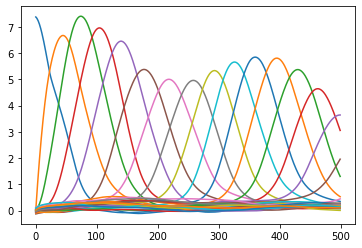

In [105]:
for overlap in overlaps:
    plt.plot(overlap[:]);

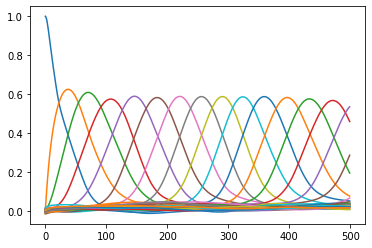

In [106]:
for overlap in correlations:
    plt.plot(overlap[:]);

Field statistics

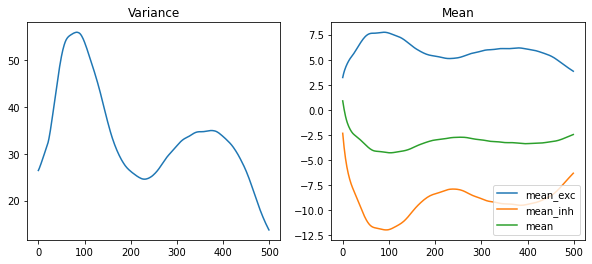

In [107]:
state_exc = net.exc.state
state_inh = net.inh.state
M = np.mean(net.exc.phi(state_exc)**2, axis=0)

r_sum_exc = conn_EE.W.dot(net.exc.phi(state_exc))
r_sum_inh = conn_EI.W.dot(net.inh.phi(state_inh))

field_var = (conn_EE.W.dot(net.exc.phi(state_exc)) + conn_EI.W.dot(net.inh.phi(state_inh))).var(axis=0)
field_mean_exc = r_sum_exc.mean(axis=0)
field_mean_inh = r_sum_inh.mean(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(field_var)
ax[1].plot(field_mean_exc, label="mean_exc")
ax[1].plot(field_mean_inh, label="mean_inh")
ax[1].plot(field_mean_exc+field_mean_inh, label="mean")
ax[0].set_title("Variance")
ax[1].set_title("Mean")
plt.legend();